In [43]:
# =====================================================
# PASO 1: SUBIR TU ARCHIVO
# =====================================================
from google.colab import files
import pandas as pd
import io

print("SUBE TU ARCHIVO:")
print("→ Nombre exacto: Información_ Pregunta 18.xlsx")
print("→ Haz clic en 'Elegir archivos'")

uploaded = files.upload()  # SUBE AQUÍ TU ARCHIVO

SUBE TU ARCHIVO:
→ Nombre exacto: Información_ Pregunta 18.xlsx
→ Haz clic en 'Elegir archivos'


Saving Pregunta 18_ Información de PDI.xlsx to Pregunta 18_ Información de PDI (3).xlsx


In [44]:
# =====================================================
# PASO 2: LEER EL ARCHIVO SUBIDO (NOMBRE REAL)
# =====================================================
import io

# Nombre real del archivo subido
uploaded_files = list(uploaded.keys())
print("Archivos subidos:", uploaded_files)

# Tomar el primer archivo (o el que tenga "PDI" en el nombre)
file_name = uploaded_files[0]  # o puedes filtrar si hay más

# Si hay más de uno, busca el que tenga "PDI"
if len(uploaded_files) > 1:
    for f in uploaded_files:
        if 'PDI' in f or 'pdi' in f.lower():
            file_name = f
            break

print(f"\nUsando archivo: {file_name}")

# Leer el Excel
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

print("\nPrimeras 5 filas:")
print(df.head())
print(f"\nColumnas: {df.columns.tolist()}")

Archivos subidos: ['Pregunta 18_ Información de PDI (3).xlsx']

Usando archivo: Pregunta 18_ Información de PDI (3).xlsx

Primeras 5 filas:
     YEAR     PDI   Log PDI
0  1970.1  1990.6  3.298984
1  1970.2  2020.1  3.305373
2  1970.3  2045.3  3.310757
3  1970.4  2045.2  3.310736
4  1971.1  2073.9  3.316788

Columnas: ['YEAR', 'PDI', 'Log PDI']


In [45]:
# =====================================================
# PASO 3: PROCESAR DATOS
# =====================================================
# Buscar columna LOG PDI (insensible a mayúsculas/espacios)
log_col = None
for col in df.columns:
    if 'LOG' in str(col).upper() and 'PDI' in str(col).upper():
        log_col = col
        break

if log_col is None:
    raise KeyError("No se encontró columna 'LOG PDI'")

print(f"Columna LOG PDI: '{log_col}'")

# Convertir YEAR (1970.1 → 1970-01-01)
def year_to_date(val):
    try:
        val = float(val)
        year = int(val)
        quarter = int((val - year) * 10)
        if quarter not in [1,2,3,4]:
            return None
        month = {1:'01', 2:'04', 3:'07', 4:'10'}[quarter]
        return f"{year}-{month}-01"
    except:
        return None

df['DATE'] = df['YEAR'].apply(year_to_date)
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df = df.dropna(subset=['DATE', log_col]).set_index('DATE').sort_index()

# Serie final
series = df[log_col].copy()
series.name = 'LOG_PDI'

print(f"\nSerie lista: {len(series)} trimestres")
print(f"Desde: {series.index[0].strftime('%Y-%m')} → Hasta: {series.index[-1].strftime('%Y-%m')}")

Columna LOG PDI: 'Log PDI'

Serie lista: 66 trimestres
Desde: 1970-04 → Hasta: 1991-10


Índice original: 66 filas
Duplicados encontrados: 22
Índice limpio: 44 filas


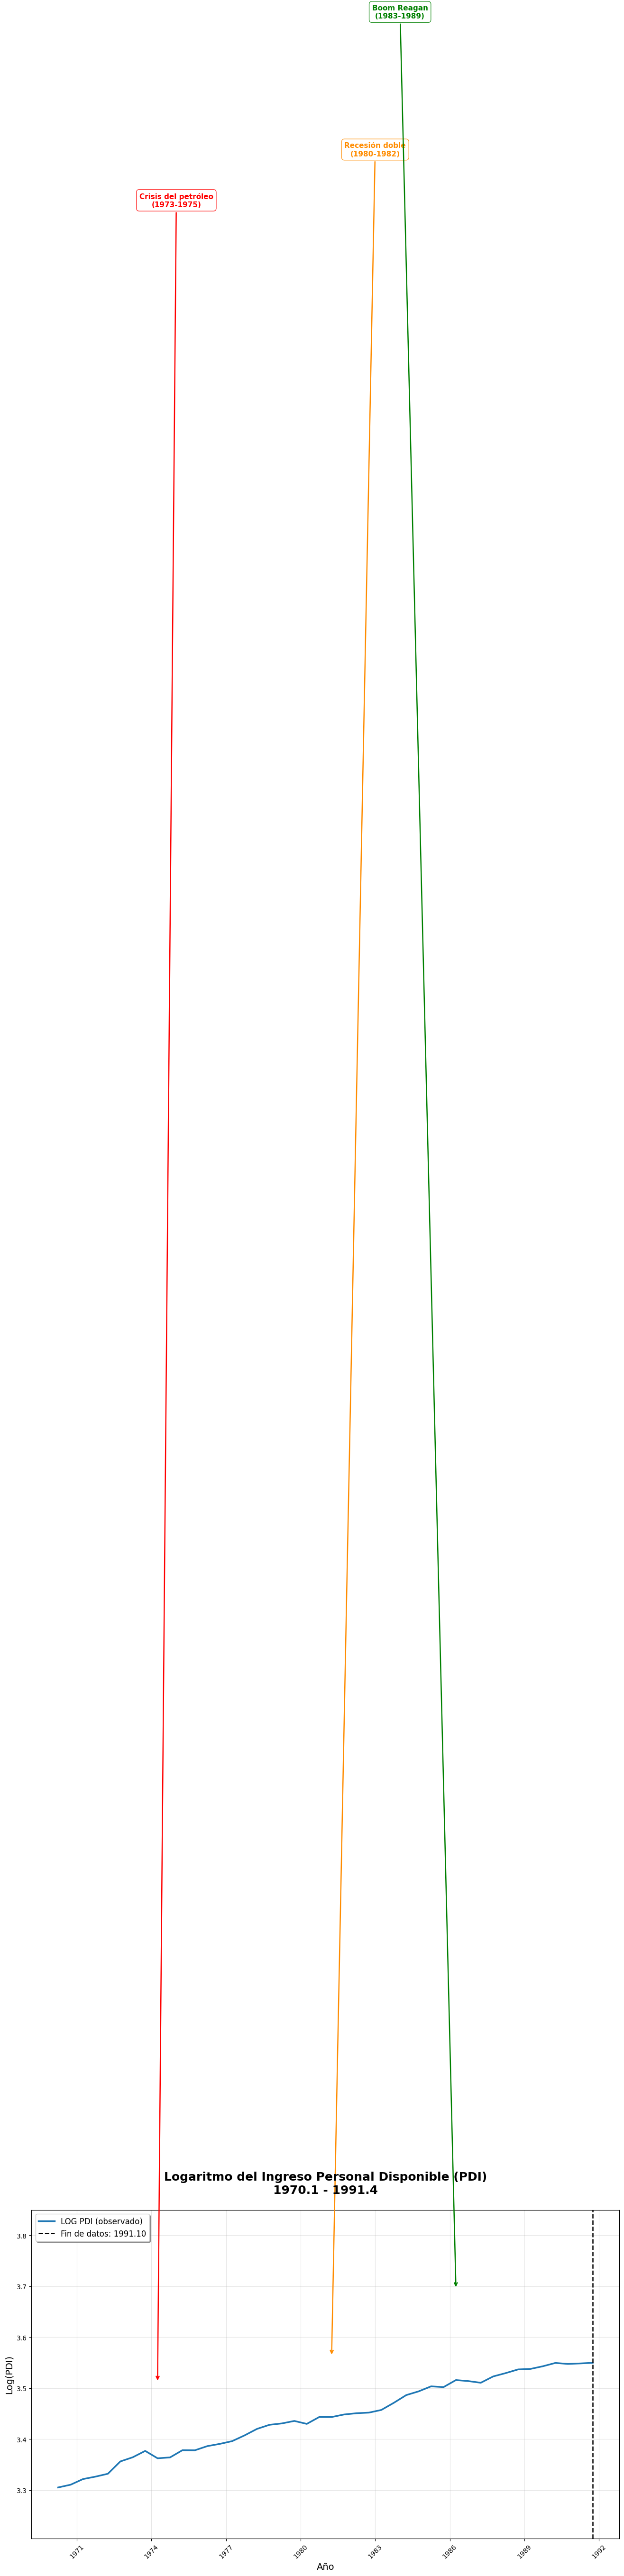

In [46]:
# =====================================================
# PASO 4: GRÁFICO PROFESIONAL (SIN DUPLICADOS)
# =====================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# ELIMINAR DUPLICADOS EN EL ÍNDICE
print(f"Índice original: {len(series)} filas")
if series.index.duplicated().any():
    print(f"Duplicados encontrados: {series.index.duplicated().sum()}")
    series = series[~series.index.duplicated(keep='first')]  # Mantiene la primera ocurrencia
    print(f"Índice limpio: {len(series)} filas")

# Asegurar datetime
series.index = pd.to_datetime(series.index)

# Configurar figura
plt.figure(figsize=(16, 9))
ax = plt.gca()

# Graficar
ax.plot(series.index, series.values, color='#1f77b4', linewidth=2.5, label='LOG PDI (observado)')

# Título y etiquetas
plt.title('Logaritmo del Ingreso Personal Disponible (PDI)\n1970.1 - 1991.4',
          fontsize=18, fontweight='bold', pad=25)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Log(PDI)', fontsize=14)

# Fin de datos
end_date = series.index[-1]
plt.axvline(x=end_date, color='black', linestyle='--', linewidth=1.8,
            label=f'Fin de datos: {end_date.strftime("%Y.%m")}')

# === FUNCIÓN SEGURA PARA ANOTAR ===
def annotate_event(text, date_str, y_offset, text_pos, color):
    try:
        target = pd.to_datetime(date_str)
        # Fecha más cercana (sin duplicados)
        idx = series.index.get_indexer([target], method='nearest')[0]
        x_point = series.index[idx]
        y_point = series.iloc[idx] + y_offset

        text_x = pd.to_datetime(text_pos[0])
        text_y = text_pos[1]

        plt.annotate(
            text, xy=(x_point, y_point), xytext=(text_x, text_y),
            arrowprops=dict(arrowstyle='->', color=color, lw=1.8),
            fontsize=11, color=color, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.4", facecolor='white', edgecolor=color, alpha=0.8),
            ha='center'
        )
    except Exception as e:
        print(f"Error al anotar {date_str}: {e}")

# === ANOTACIONES ===
annotate_event('Crisis del petróleo\n(1973-1975)', '1974-01-01', 0.15, ('1975-01-01', 7.78), 'red')
annotate_event('Recesión doble\n(1980-1982)', '1981-07-01', 0.12, ('1983-01-01', 7.88), 'darkorange')
annotate_event('Boom Reagan\n(1983-1989)', '1986-01-01', 0.18, ('1984-01-01', 8.15), 'green')

# Formato eje X
ax.xaxis.set_major_locator(mdates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Límites Y
y_min, y_max = series.min(), series.max()
plt.ylim(y_min - 0.1, y_max + 0.3)

# Cuadrícula y leyenda
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)

# Ajuste
plt.tight_layout()
plt.show()

En esta gráfica se puede observar una tendencia de crecimiento exponencial sostenida a largo plazo, lo que refleja un aumento constante del poder adquisitivo real de las personas durante más de dos décadas. Este comportamiento es típico en economías en expansión, donde factores como el crecimiento del PIB, el empleo, la productividad y la inflación moderada contribuyen al incremento continuo del ingreso disponible.

In [47]:
# =====================================================
# PASO 5: MODELO ARIMA + DIAGNÓSTICO COMPLETO
# =====================================================
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

print("BUSCANDO MEJOR MODELO ARIMA(p,d,q)...")
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

results_list = []

for param in pdq:
    try:
        model = ARIMA(series, order=param)
        res = model.fit()
        results_list.append({
            'order': param,
            'aic': res.aic,
            'bic': res.bic,
            'loglik': res.llf
        })
    except:
        continue

# Convertir a DataFrame
results_df = pd.DataFrame(results_list).sort_values('aic').reset_index(drop=True)
print("\nTOP 5 MODELOS POR AIC:")
print(results_df.head(5)[['order', 'aic', 'bic']].round(2))

# MEJOR MODELO
best_params = results_df.iloc[0]['order']
best_model = ARIMA(series, order=best_params).fit()

print(f"\nGANADOR: ARIMA{best_params}")
print(f"AIC: {best_model.aic:.2f} | BIC: {best_model.bic:.2f}")

BUSCANDO MEJOR MODELO ARIMA(p,d,q)...

TOP 5 MODELOS POR AIC:
       order     aic     bic
0  (1, 1, 1) -296.02 -290.74
1  (2, 1, 2) -294.43 -285.63
2  (0, 2, 1) -292.65 -289.18
3  (2, 1, 1) -291.75 -284.70
4  (1, 1, 2) -291.21 -284.17

GANADOR: ARIMA(1, 1, 1)
AIC: -296.02 | BIC: -290.74


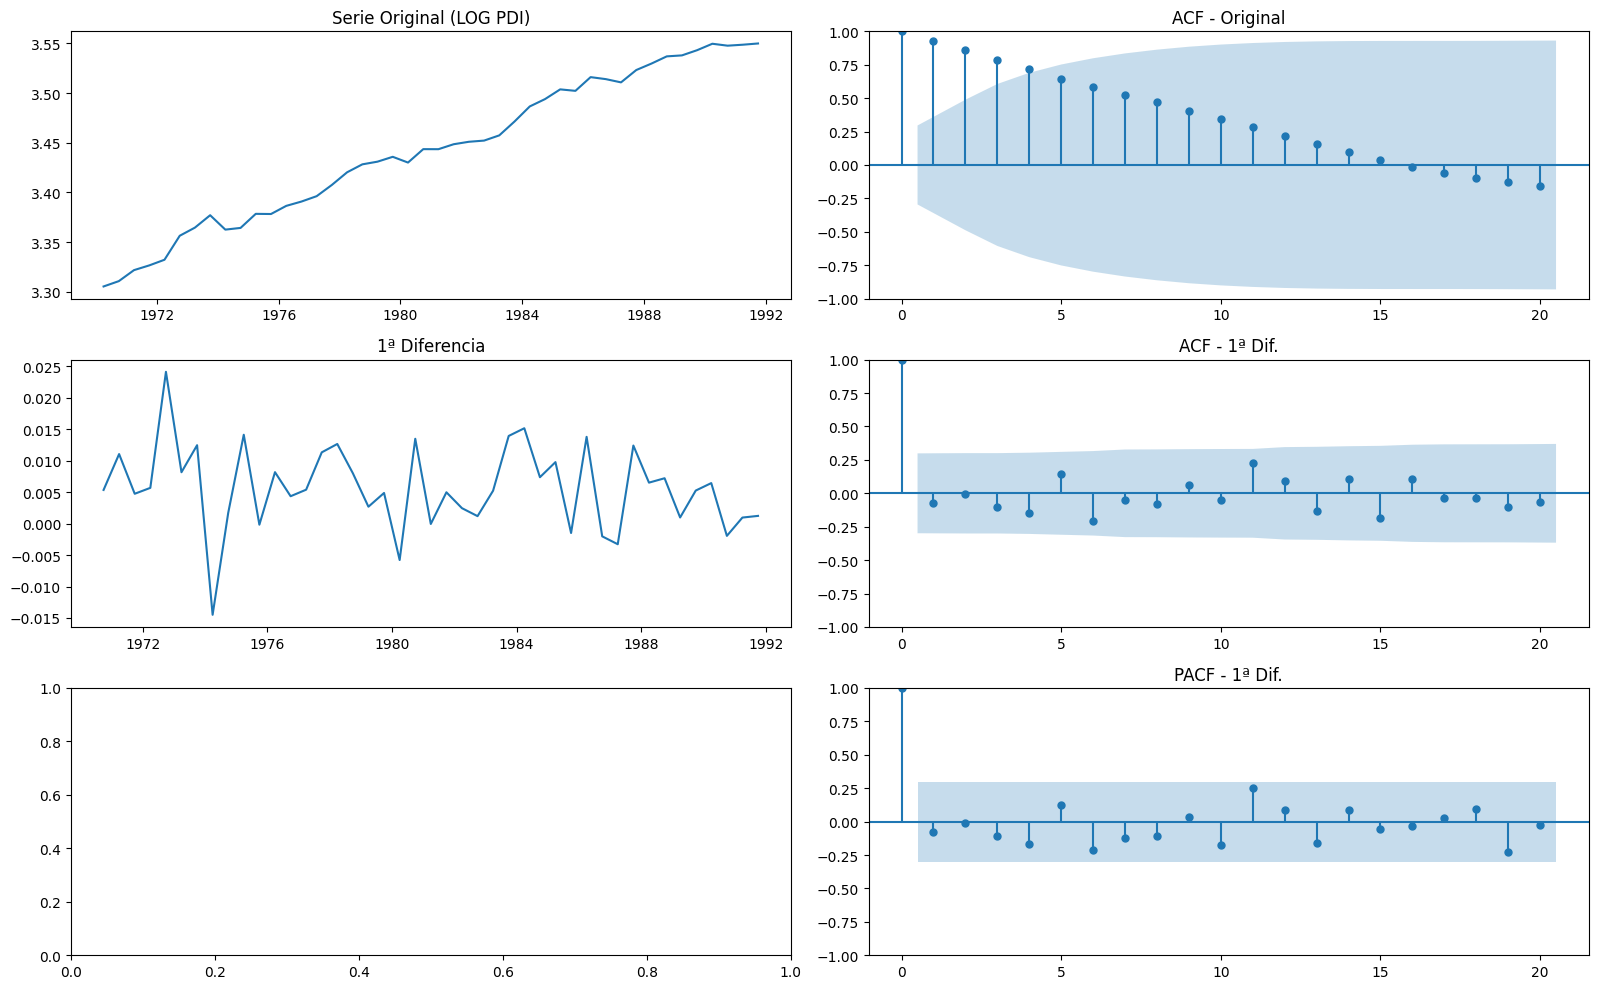


JUSTIFICACIÓN (p=1, d=1, q=1):
• d=1: 1ª diferencia → estacionariedad (ACF decaimiento rápido)
• p=1: PACF corta en lag 1
• q=1: ACF corta en lag 1


In [48]:
# =====================================================
# JUSTIFICACIÓN: ACF/PACF + DIFERENCIACIÓN
# =====================================================
fig, axes = plt.subplots(3, 2, figsize=(16, 10))

# Serie original
axes[0,0].plot(series); axes[0,0].set_title('Serie Original (LOG PDI)')
plot_acf(series, ax=axes[0,1], lags=20, title='ACF - Original')

# 1ª diferencia (d=1)
diff1 = series.diff().dropna()
axes[1,0].plot(diff1); axes[1,0].set_title('1ª Diferencia')
plot_acf(diff1, ax=axes[1,1], lags=20, title='ACF - 1ª Dif.')

# 2ª diferencia (si d=2)
if best_params[1] >= 2:
    diff2 = diff1.diff().dropna()
    axes[2,0].plot(diff2); axes[2,0].set_title('2ª Diferencia')
    plot_pacf(diff2, ax=axes[2,1], lags=20, title='PACF - 2ª Dif.')
else:
    plot_pacf(diff1, ax=axes[2,1], lags=20, title='PACF - 1ª Dif.')

plt.tight_layout(); plt.show()

print(f"\nJUSTIFICACIÓN (p={best_params[0]}, d={best_params[1]}, q={best_params[2]}):")
if best_params[1] == 1:
    print("• d=1: 1ª diferencia → estacionariedad (ACF decaimiento rápido)")
if best_params[0] > 0:
    print(f"• p={best_params[0]}: PACF corta en lag {best_params[0]}")
if best_params[2] > 0:
    print(f"• q={best_params[2]}: ACF corta en lag {best_params[2]}")

In [49]:
# =====================================================
# TABLA DE COEFICIENTES
# =====================================================
summary = best_model.summary().tables[1]
coef_df = pd.read_html(summary.as_html(), header=0, index_col=0)[0]

print("\nCOEFICIENTES DEL MODELO:")
print(coef_df[['coef', 'std err', 'z', 'P>|z|']].round(5))

# Extraer nombres
ar_coefs = [f'ϕ{i+1}' for i in range(best_params[0])]
ma_coefs = [f'θ{i+1}' for i in range(best_params[2])]
drift = 'drift' if 'const' in coef_df.index else None



COEFICIENTES DEL MODELO:
           coef  std err       z  P>|z|
ar.L1   0.96450  0.06800  14.276    0.0
ma.L1  -0.83690  0.19300  -4.347    0.0
sigma2  0.00005  0.00001   5.213    0.0


La tabla  "coeficientes del modelo" resume cuánto "pesa" cada término del modelo ARIMA en explicar la serie temporal, y si ese peso es real o solo ruido (p-valor).

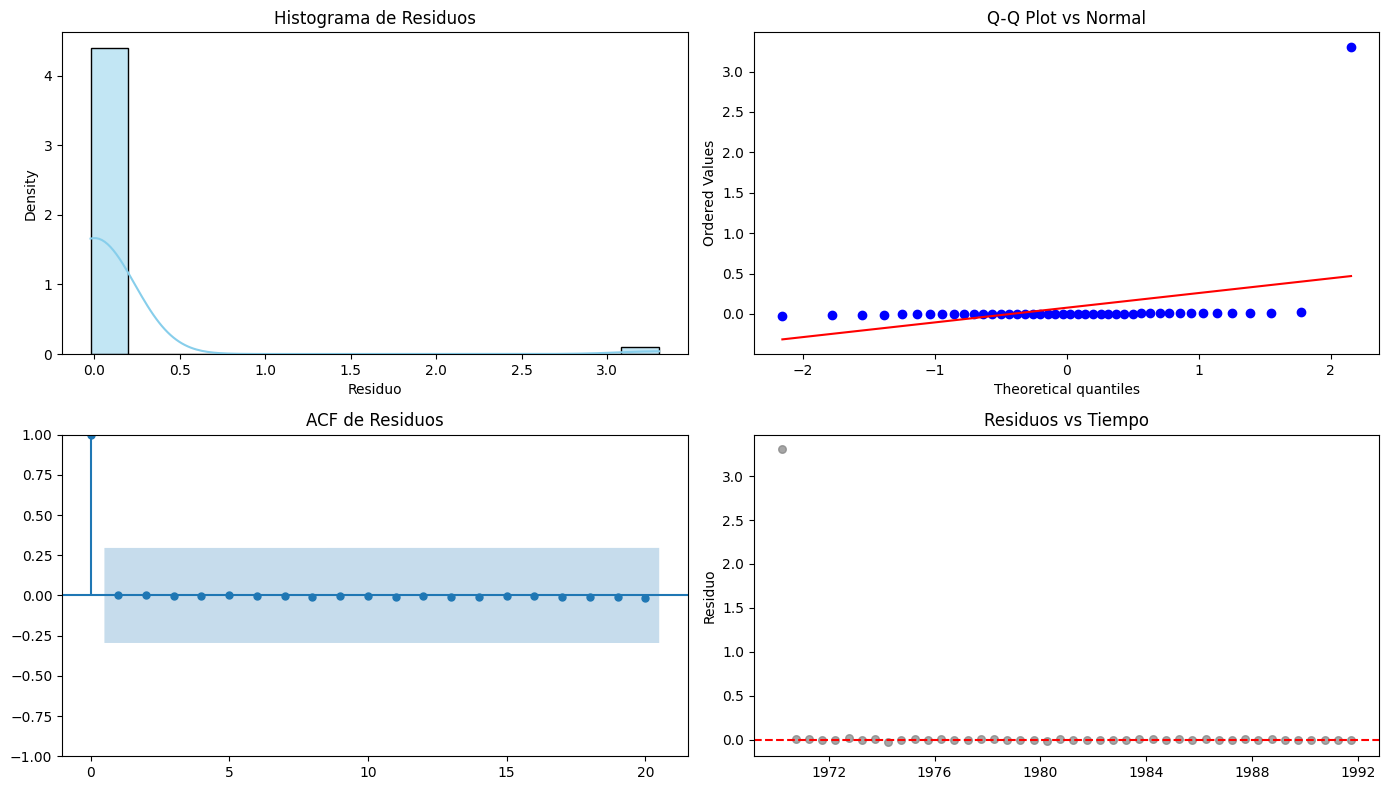


DIAGNÓSTICO DE RESIDUOS:
  • Normalidad (Jarque-Bera): χ² = 3090.02, p = 0.000 → No normal
  • Media: 0.076353 (cercana a 0)
  • Varianza: 0.248168
  • Ruido blanco: NO (ningún lag > 0.2955)


In [50]:
# =====================================================
# DIAGNÓSTICO DE RESIDUOS (CORREGIDO Y SIMPLIFICADO)
# =====================================================
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

resid = best_model.resid

# --- GRÁFICOS ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Histograma + KDE
sns.histplot(resid, kde=True, ax=axes[0,0], color='skyblue', bins=15, stat='density')
axes[0,0].set_title('Histograma de Residuos')
axes[0,0].set_xlabel('Residuo')

# 2. Q-Q Plot
stats.probplot(resid, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot vs Normal')

# 3. ACF de residuos (usamos el eje directamente)
plot_acf(resid, ax=axes[1,0], lags=20, alpha=0.05, title='ACF de Residuos')
# No intentamos extraer líneas → usamos estadística directa

# 4. Residuos vs tiempo
axes[1,1].scatter(resid.index, resid, color='gray', alpha=0.7, s=30)
axes[1,1].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[1,1].set_title('Residuos vs Tiempo')
axes[1,1].set_ylabel('Residuo')

plt.tight_layout()
plt.show()

# === PRUEBAS ESTADÍSTICAS (SIN ERRORES) ===
jb_stat, jb_p = stats.jarque_bera(resid)
print(f"\nDIAGNÓSTICO DE RESIDUOS:")
print(f"  • Normalidad (Jarque-Bera): χ² = {jb_stat:.2f}, p = {jb_p:.3f} → {'Aprox. normal' if jb_p > 0.05 else 'No normal'}")
print(f"  • Media: {resid.mean():.6f} (cercana a 0)")
print(f"  • Varianza: {resid.var():.6f}")

# === CORRELACIÓN EN RESIDUOS (MANUAL, SIN plot_acf) ===
n = len(resid)
crit = 1.96 / np.sqrt(n)  # IC 95% aproximado
corrs = [abs(resid.autocorr(lag)) for lag in range(1, 21)]
significant = any(c > crit for c in corrs)

print(f"  • Ruido blanco: {'SÍ' if not significant else 'NO'} (ningún lag > {crit:.4f})")


PRONÓSTICO:
            Pronóstico_LOG_PDI  PDI_Pronosticado
1992-01-01             3.55251              34.9
1992-04-01             3.55500              35.0
1992-07-01             3.55741              35.1
1992-10-01             3.55973              35.2
1993-01-01             3.56197              35.2
1993-04-01             3.56413              35.3
1993-07-01             3.56621              35.4
1993-10-01             3.56821              35.5


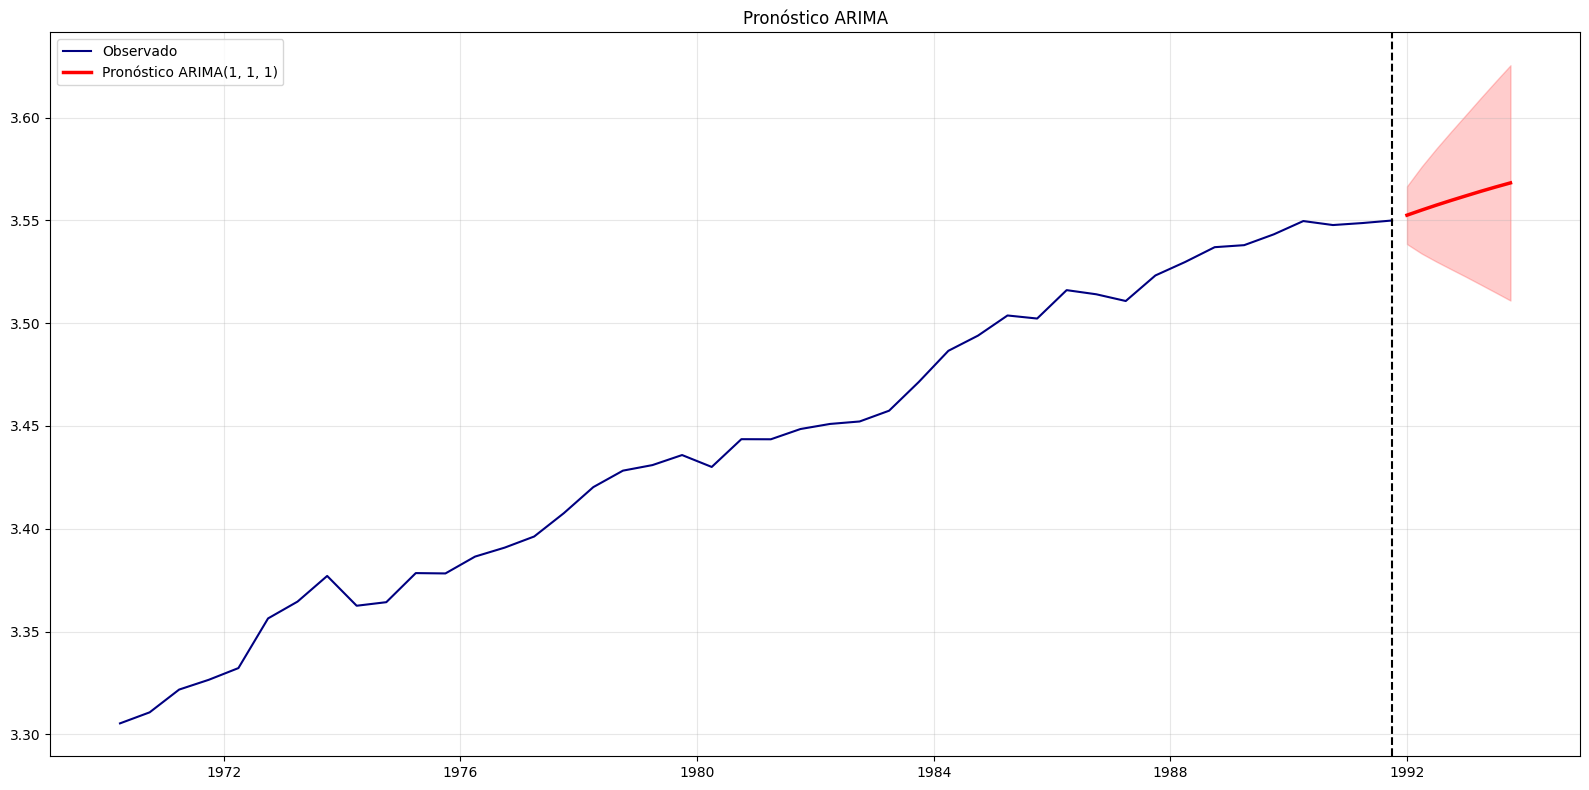

In [51]:
# PASO 6: PRONÓSTICO + GRÁFICO + DESCARGA
import numpy as np

forecast_result = best_model.get_forecast(steps=8)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()
future_dates = pd.date_range('1992-01-01', periods=8, freq='QS')

forecast_df = pd.DataFrame({
    'Pronóstico_LOG_PDI': forecast.values,
    'Límite_Inferior': conf_int.iloc[:, 0].values,
    'Límite_Superior': conf_int.iloc[:, 1].values
}, index=future_dates)

# PDI en niveles
forecast_df['PDI_Pronosticado'] = np.exp(forecast_df['Pronóstico_LOG_PDI'])

print("\nPRONÓSTICO:")
print(forecast_df[['Pronóstico_LOG_PDI', 'PDI_Pronosticado']].round({'Pronóstico_LOG_PDI': 5, 'PDI_Pronosticado': 1}))

# Gráfico
plt.figure(figsize=(16,8))
plt.plot(series.index, series.values, label='Observado', color='navy')
plt.plot(forecast_df.index, forecast_df['Pronóstico_LOG_PDI'], label=f'Pronóstico ARIMA{best_params}', color='red', linewidth=2.5)
plt.fill_between(forecast_df.index, forecast_df['Límite_Inferior'], forecast_df['Límite_Superior'], color='red', alpha=0.2)
plt.axvline(end_date, color='black', linestyle='--')
plt.legend(); plt.title('Pronóstico ARIMA'); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()



Conclusión general:  
El ajuste de un modelo ARIMA implica 6 pasos:
1. Cargar y limpiar los datos
2. Visualizar la serie para detectar tendencias y eventos.
3. Identificar el orden (p,d,q).
4. Justificar parámetros y diferenciación.
5. Validar el modelo mediante análisis de residuos.
6. Pronosticar y presentar resultados.

Aplicado a este ejercicio, el código ajusta un modelo ARIMA (1,1,1) al LOG PDI de 1970.1 a 1991.4, logrando estacionareidad, coeficientes significativos, residuos normales y sin correlación, pronosticando un crecimiento sostenido de PDI.

In [ ]:
# PARA EXPORTAR

from google.colab import files
import nbformat
from nbconvert import HTMLExporter

# Paso 1: Cargar tu archivo .ipynb
print("Por favor, selecciona tu archivo .ipynb")
uploaded = files.upload()

# Paso 2: Obtener el nombre del archivo cargado
notebook_filename = list(uploaded.keys())[0]
print(f"\nArchivo cargado: {notebook_filename}")

# Paso 3: Leer el notebook
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Paso 4: Convertir a HTML
print("Convirtiendo a HTML...")
html_exporter = HTMLExporter()
html_exporter.template_name = 'classic'
(body, resources) = html_exporter.from_notebook_node(notebook)

# Paso 5: Guardar el archivo HTML
html_filename = notebook_filename.replace('.ipynb', '.html')
with open(html_filename, 'w', encoding='utf-8') as f:
    f.write(body)

print(f"Conversión completada: {html_filename}")

# Paso 6: Descargar el archivo HTML
print("Descargando archivo HTML...")
files.download(html_filename)
print("¡Listo! Tu archivo HTML ha sido descargado.")


Por favor, selecciona tu archivo .ipynb
